<a href="https://colab.research.google.com/github/TheAmirHK/Portfolio-analysis-and-optimization/blob/main/Stock_technical_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
""" This article analyzes important financial ratios of a single stock compared to the market (e.g. GSPC),,
    as well as others in the technology, motor production, and healthcare domains. This information can then be used for portfolio optimization..
"""

import pandas_datareader.data as web
import datetime
from datetime import datetime, date, timedelta
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from pandas_datareader import data as pdr
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

# For warnings suppression
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# A function to download stocks' adjusted close price
def receive_data(tickers, start, end):
    adj_close_df = pd.DataFrame()
    for ticker in tickers:
        data = pdr.get_data_yahoo(ticker, start, end, progress=False)
        adj_close_df[ticker] = data["Adj Close"]
    return adj_close_df


In [ ]:
# plot the correlation matrix

def evaluate_corr(data):
    Correlation = data.corr()
    Correlation = np.tril(Correlation,-1)
    sns.heatmap(Correlation, annot=True, mask = (Correlation ==0), xticklabels = stocks, yticklabels = stocks, label= "Stocks' correleation" )
    return

In [ ]:
# A function to normalize prices
def daily_return(data):
    log_returns = data.pct_change().dropna()
    return log_returns

In [ ]:
# To calculate the beta, we need the covariance between the specific stock and the market (e.g. GSPC).

def calculate_covariance(data):
    covariance = pd.DataFrame()
    log_returns = daily_return(data)
    covariance = log_returns.cov()*252 #Annualize by multiplying by 252 (trading days in a year)
    return covariance

In [ ]:
# A function to calculate annualized flunctuation of the price of a specific period
def calculate_volatility (data):
    log_returns = daily_return(data)
    volatility_list = (log_returns.std()*np.sqrt(252)).dropna()
    return volatility_list

In [ ]:
# A stock's beta measures how risky, or volatile, a stock's price is compared to the entire market (e.g. GSPC).
def calculate_beta (data):
    beta = pd.DataFrame()
    covariance = calculate_covariance(data)
    vol =  calculate_volatility (data)
    stock_covariance = covariance.iloc[:,-1]
    market_var = covariance.iloc[-1,-1]
    beta = stock_covariance/market_var
    return beta

In [ ]:
# The Capital Asset Pricing Model (CAPM) is a mathematical model used to estimate the expected return of an investment based on its risk level relative to the market (e.g. GSPC).

def CAPM(data, Rf):
    daily_log = daily_return(data)
    beta = calculate_beta(data)
    var = (daily_log.var())*252
    expected_return = daily_log.mean()*252
    CAPM_value = Rf + beta*(expected_return.iloc[-1] - Rf)
    sharpe_ratio = ( expected_return - Rf ) /np.sqrt(var)
    sharr =    ( expected_return.dropna() - Rf ) /np.sqrt(var)
    ten = (expected_return.dropna() - Rf)/beta
    return CAPM_value

In [ ]:
#  Sharpe Ratio measures the excess return over the risk-free rate.

def Sharpe_ratio(data, Rf):
    daily_log = daily_return(data)
    var = (daily_log.var())*252
    expected_return = daily_log.mean()*252
    sharpe_value = ( expected_return.dropna() - Rf ) /np.sqrt(var)
    return sharpe_value

In [ ]:
# Treynor ratio measures a portfolio's excess return per unit of systematic risk, i.e. the market volatility of the portfolio.

def Treynor_ratio(data, Rf):
    daily_log = daily_return(data)
    beta = calculate_beta(data)
    expected_return = daily_log.mean()*252
    tren = (expected_return.dropna() - Rf)/beta
    return tren

In [ ]:
# M2 measures risk-adjusted returns of an investment portfolio.

def M2(data, Rf):
    daily_log = daily_return(data)
    beta = calculate_beta(data)
    std_stock = (daily_log.std())*np.sqrt(252)
    expected_return = daily_log.mean()*252
    m2_value = ((expected_return.dropna() - Rf)*std_stock/std_stock['GSPC']) - (expected_return['GSPC'] - Rf)
    return m2_value

In [ ]:
# Jensens (Alpha) represents the average return on a portfolio or investment, above or below that expected by the capital asset pricing model (CAPM)

def Jensens_alpha (data, Rf):
    daily_log = daily_return(data)
    beta = calculate_beta(data)
    expected_return = daily_log.mean()*252
    Jensens_alpha_value = expected_return - (Rf + beta * (expected_return['GSPC'] -Rf) )
    return Jensens_alpha_value

In [ ]:
# Information Ratio evaluates the excess return relative to a market (e.g. GSPC).

def Information_ratio(data):
    daily_log = daily_return(data)
    expected_return = daily_log.mean()*252
    dif = expected_return.iloc[:-1] - expected_return['GSPC']
    error = dif.std()*np.sqrt(252)
    Info_ratio = dif/error
    return dif

In [ ]:
# The Sortino Ratio shows an adjusted measure of return by comparing the instrument price performance to a risk-free return.

def Sortino_ratio(data, Rf):
    daily_log = daily_return(data)
    expected_return = (daily_log.mean())*252
    std_neg = (daily_log[daily_log<0].std())*np.sqrt(252)
    sortino_value = (expected_return - Rf)/std_neg
    return sortino_value

In [ ]:
def comaprison (data, Rf):
    result = pd.DataFrame()
    result["Volatility"] = calculate_volatility (data)
    result["Beta"] = calculate_beta (data)
    result["CAPM"] = CAPM(data, Rf)
    result["Sharpe ratio"] = Sharpe_ratio(data, Rf)
    result["Treynor ratio"] = Treynor_ratio(data, Rf)
    result["M2"] = M2(data, Rf)
    result["Jensen's alpha"] = Jensens_alpha (data, Rf)
    result["Sortino ratio"] = Sortino_ratio(data, Rf)
    result["Information ratio"] = Information_ratio(data)
    result.plot(kind="barh", subplots=True, layout=(3,3),
                figsize=(14, 14), xlabel= "Ratio", sharex = False, grid = "True", fontsize = 7)
    plt.figure("Stocks' correlation")
    fig = evaluate_corr(data)
    return result


In [ ]:
# Eahc individual stocks to be analyzed !
stocks = ["AAPL", "MSFT", "GOOG", "AMZN",   # Technology stocks
          "TSLA", "TM", "MBGYY", "VWAGY", "VLVLY", "GM",  # Motor manufacturing stocks
          "LLY", "JNJ", "AZN"] # Health market stocks
market = ['^GSPC'] # S&P500 index

# define the number of years to be studied
NYears = 5

# Risk-free asset rate
Rf = 0.02

# Define the time period of study
end = datetime.today()
start = end - timedelta(days = NYears*365)
print("Start date:%str   End date:%str" %(start, end))

stock_data = receive_data(stocks, start, end)
market_data = receive_data(market, start, end)
stock_market_data = stock_data.assign( GSPC = market_data['^GSPC'])

Start date:2018-11-26 20:30:56.034295tr   End date:2023-11-25 20:30:56.034295tr


,Volatility,Beta,CAPM,Sharpe ratio,Treynor ratio,M2,Jensen's alpha,Sortino ratio,Information ratio
AAPL,0.327162,1.223031,0.154532,1.031286,0.275870,0.399978,0.202865,1.434052,0.227398
MSFT,0.309434,1.190411,0.150944,0.940493,0.244470,0.306044,0.160077,1.315073,0.181022
GOOG,0.320369,1.133381,0.144671,0.707597,0.200014,0.225534,0.102022,0.974444,0.116694
AMZN,0.360444,1.092875,0.140215,0.468696,0.154582,0.171330,0.048724,0.680704,0.058940
TSLA,0.651242,1.498910,0.184878,1.012892,0.440078,1.874699,0.494759,1.461537,0.549639
TM,0.236512,0.660272,0.092629,0.408686,0.146393,-0.004379,0.024030,0.602050,-0.013340
MBGYY,0.408842,1.268378,0.159520,0.344318,0.110986,0.155901,0.001252,0.442863,0.030773
VWAGY,0.422702,1.129920,0.144290,0.173877,0.065047,0.033536,-0.050792,0.258679,-0.036501
VLVLY,0.358296,1.135418,0.144895,0.595564,0.187938,0.243233,0.088494,0.810281,0.103390
GM,0.421016,1.272062,0.159925,0.073728,0.024402,-0.049622,-0.108885,0.106412,-0.078958


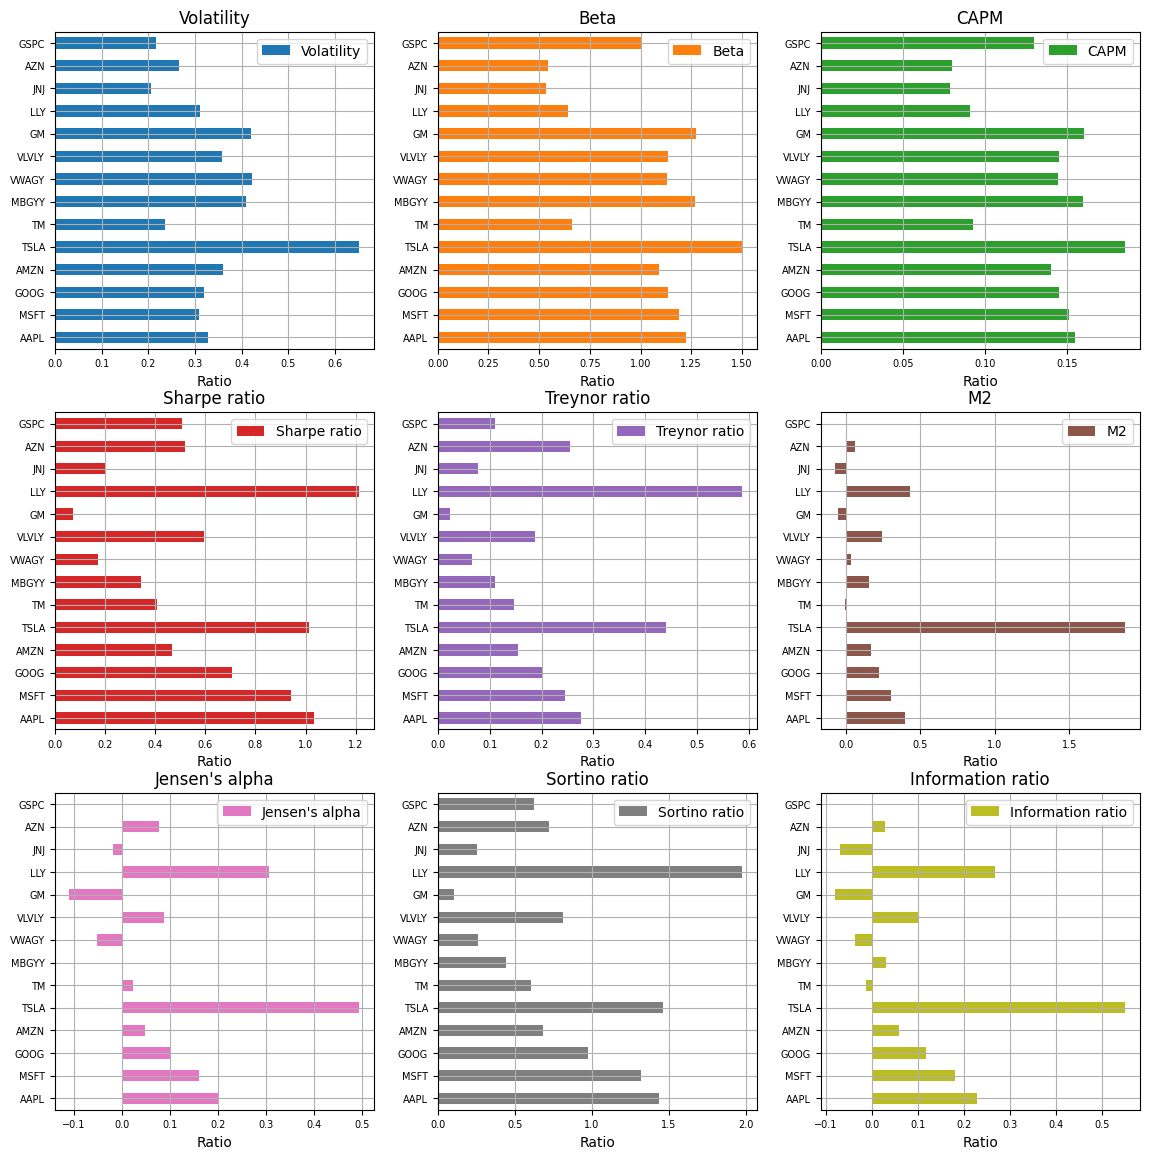

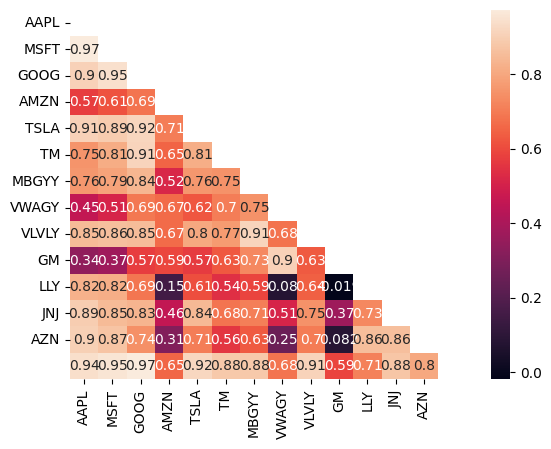

In [ ]:
comaprison (stock_market_data, Rf)